# AISE4010 — Assignment 1 
### Time Series Forecasting with Autoregressive Models and MLP 

**Grade:** 100 points

## Instructions
Follow these steps before submitting your assignment:
1. Complete the notebook.
2. Make sure **all plots have axis labels**.
3. When finished, go to **Kernel → Restart & Run All** to ensure a clean, error‑free run.
4. Fix any errors until your notebook runs without problems.
5. Submit **one completed notebook** per group to OWL by the deadline.
6. Reference all external code and documentation you use.

## Dataset 
- **File:** `weather.csv`
- **Location:** Szeged, Hungary
- **Frequency:** Daily (fixed calendar index)
- **Time span:** ≈ 2006–2016
- **Target:** `Temperature (C)`
- **Key variables:** Temperature (C), Pressure (millibars), Humidity, Appar Temperature (C), Wind Speed (km/h), Wind Bearing (degrees), Visibility (km)


## Question 1: Data Preprocessing (25%)

### Q1.1 Exploratory Data Analysis (2%)
1. Load the dataset and print the **first 6 rows**.  
2. Encode categorical variables (one‑hot). *(If none, report "none.")*


In [1]:
import pandas as pd

#load dataset
data = pd.read_csv("C:/Users/sixel/fourth year/4410/assignments/1/weather.csv")

#display first 6 rows
print(data.head(6))

  Formatted Date  Temperature (C)  Apparent Temperature (C)  Humidity  \
0     2005-12-31              0.6                      -4.0      0.89   
1     2006-01-01              4.1                      -0.2      0.82   
2     2006-01-02              5.3                       1.8      0.85   
3     2006-01-03              2.3                       0.4      0.90   
4     2006-01-04              2.3                      -0.7      0.91   
5     2006-01-05              2.7                       0.4      0.95   

   Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  \
0               17.1                   140.0             10.0   
1               21.2                   143.0             11.3   
2               17.8                   165.0              8.5   
3                7.7                   253.0              9.2   
4               12.2                    35.0              8.4   
5                9.0                   140.0              4.3   

   Pressure (millibars)  
0     

In [ ]:
#check for categorial columns
cat_col=data.select_dtypes(include=['object']).columns
print("categorial cols found: ", list(cat_col))

#one hot encoding
if len(cat_col)>0: 
    data_encode=pd.get_dummies(data, columns=cat_col,drop_first=True)
    print("one hot encoding applied to ...", list(cat_col))
else: 
    data_encode=data.copy()
    print("no categorial columns")

categorial cols found:  ['Formatted Date']
one hot encoding applied to ... ['Formatted Date']


### Q1.2 Handling Missing Data (11%)
1. Report missingness (**counts & %**) and show a heatmap for **Temperature, Pressure, Humidity**.
2. Use these two imputation methods:\
   a) Forward-fill (FFill).\
   b) Linear time interpolation.
3. Pick one method and save the result as `daily_clean`.
4. **Discussion** Which imputation method did you pick and why?  
5. **Discussion** How might your choice bias trend/seasonality estimates?  
6. **Discussion** Would your choice change if the gap were 30 days instead of 7? Explain briefly.


                          Missingness:   Missing %: 
Formatted Date                        0         0.00
Temperature (C)                      47         1.17
Apparent Temperature (C)              0         0.00
Humidity                             40         1.00
Wind Speed (km/h)                     0         0.00
Wind Bearing (degrees)                0         0.00
Visibility (km)                       0         0.00
Pressure (millibars)                 47         1.17


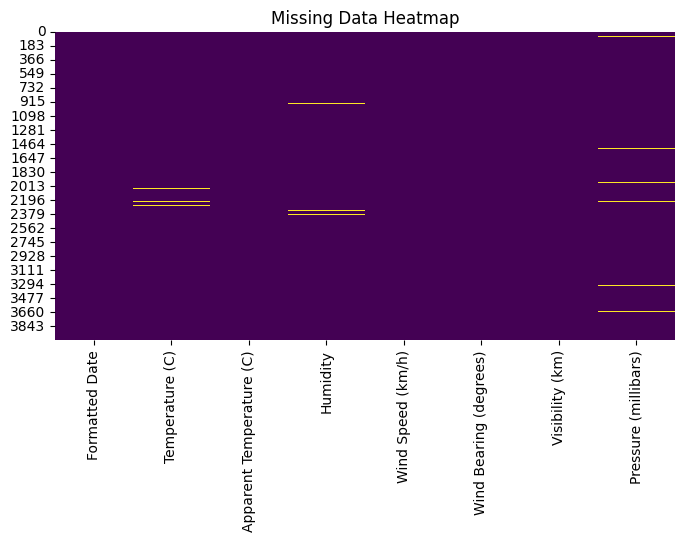

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

#show missing data
#create new data frame with NaN values as true
missing_data=data.isna().sum() 
missing_perc=(missing_data/len(data))*100

missing_summary=pd.DataFrame({
    "Missingness: ":missing_data, "Missing %: ": missing_perc.round(2)
})
print(missing_summary)

#visualize it
plt.figure(figsize=(8,4))
sns.heatmap(data.isna(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

In [5]:
#ensure formatted date column is in right form for interpolation, 
# not just text (so it knows its time), make it index so it turns into time
#series dataframe (every row is indexed)

data["Formatted Date"]=pd.to_datetime(data["Formatted Date"])
data=data.set_index("Formatted Date")

# forward fill - most recent known value
data_ff = data.copy()
data_ff[["Temperature (C)", "Pressure (millibars)", "Humidity"]] = data_ff[["Temperature (C)", "Pressure (millibars)", "Humidity"]].ffill()

#linear time interpolation - uses straight line between past and next known values
data_lti=data.copy()
data_lti[["Temperature (C)", "Pressure (millibars)", "Humidity"]] = \
    data_lti[["Temperature (C)", "Pressure (millibars)", "Humidity"]].interpolate(method="time")

In [6]:
daily_clean=data_lti.copy()

**Which method did you pick and why?** I picked the linear time interpolation method because it uses a relationship between points rather than simply assuming values stay the same over time (likely doesnt). This provides a smooth variation between values not just straight lines of no changing values. Forward Fill seems unrealistic especially for weather (not going from 0 degrees to 20 in one day).

**How might your choice bias trend/seasonality estimates?** Interpolation could end up over-smoothing the dataset where true spikes in weather may occur which would dampen seasonality effects or trends/extreme weather events.

**Would your choice change if the gap were 30 days instead of 7?** Yes it would because linear time interpolation is more reasonable for short gaps rather than large gaps because it could really sway models by inventing fake values that dont reflect realistic weather patterns. 

### Q1.3 Stationarity Analysis (12%)
1. Extract the **univariate** series `Temperature_Series = daily_clean['Temperature (C)']` and `Pressure_Series = daily_clean['Pressure (millibars)'].  
2. Report the results of a stationarity test (**ADF** or **KPSS**) for both series.
3. **Discussion:** Explain your conclusion about stationary analysis of your results. 
4. Apply differencing on both series and plot **before/after** and report the stationary test results of your choice on differenced series.   
5. **Discussion:** Explain the reason for your choice of differencing technique for each series.
6. **Discussion:** Would you difference a series that is already stationary by ADF? When might that still help?

In [11]:
#extract univariate series'
temp_series=daily_clean['Temperature (C)']
press_series=daily_clean['Pressure (millibars)']

In [18]:
from statsmodels.tsa.stattools import adfuller, kpss

#adf function
def adf_test(series, name=""):
    result1 = adfuller(series.dropna())
    print(f"ADF Test for {name}")
    print(f"  Test Statistic: {result1[0]}")
    print(f"  p-value: {result1[1]}")
    print("  Stationary?" , "Yes" if result1[1] < 0.05 else "No")
    print("-"*40)

def kpss_test(series,name=""):
    result2 = kpss(series.dropna(), nlags="auto")
    print(f"KPSS Test for {name}")
    print(f"  Test Statistic: {result2[0]}")
    print(f"  p-value: {result2[1]}")
    print("  Stationary?" , "Yes" if result2[1] > 0.05 else "No")
    print("-"*40)

#run the test
adf_test(temp_series, "Temperature (C)")
kpss_test(temp_series, "Temperature (C)")
adf_test(press_series, "Pressure (millibars)")
kpss_test(press_series, "Pressure (millibars)")


ADF Test for Temperature (C)
  Test Statistic: -3.985160214665141
  p-value: 0.0014902414944360342
  Stationary? Yes
----------------------------------------
KPSS Test for Temperature (C)
  Test Statistic: 0.03551804339361899
  p-value: 0.1
  Stationary? Yes
----------------------------------------
ADF Test for Pressure (millibars)
  Test Statistic: -14.320986122573956
  p-value: 1.1413890089116514e-26
  Stationary? Yes
----------------------------------------
KPSS Test for Pressure (millibars)
  Test Statistic: 0.052146418554819975
  p-value: 0.1
  Stationary? Yes
----------------------------------------


C:\Users\sixel\AppData\Local\Temp\ipykernel_35324\1859408912.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result2 = kpss(series.dropna(), nlags="auto")
C:\Users\sixel\AppData\Local\Temp\ipykernel_35324\1859408912.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result2 = kpss(series.dropna(), nlags="auto")


**Explain your conclusion about stationary analysis of your results** This tells me that both test indicate that the temperature test is stationary since for the ADF test p=0.0014<0.05 (reject null) and for KPSS p=0.1>0.05 (fail to reject null). And it also shows that the pressure test is also stationary since for ADF p= almost 0<0.05 and for KPSS p=0.1>0.05. This means they do not need differencing. Doing both tests is good because it assumes opposite things (stationary vs non stationary) for the model, two ways of checking.

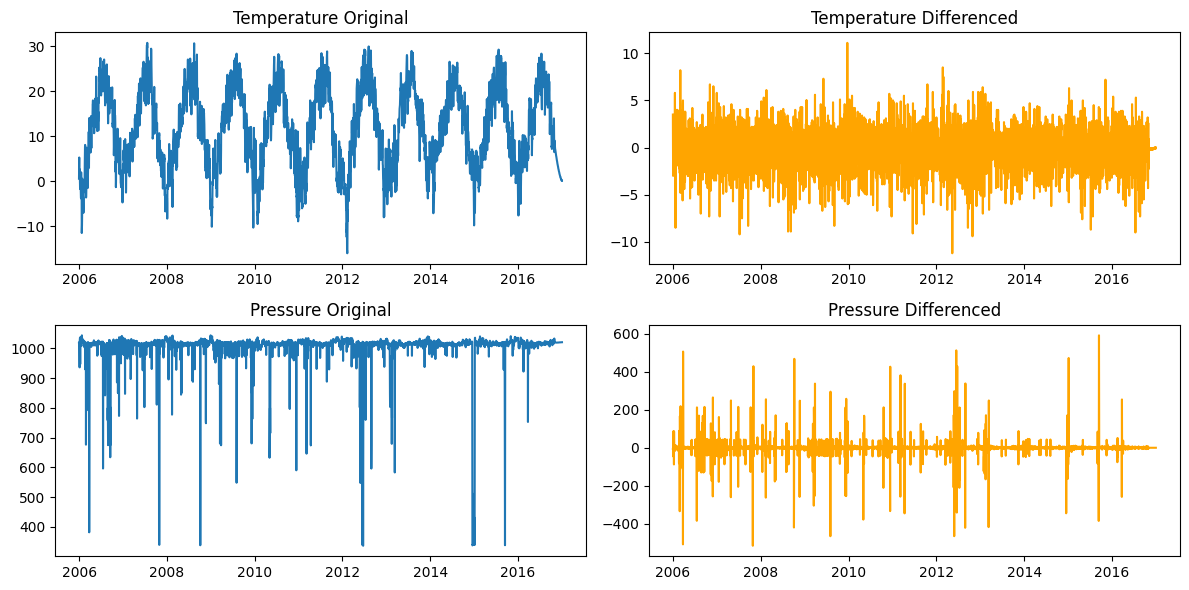

In [19]:
#differencing
temp_diff=temp_series.diff().dropna()
press_diff=press_series.diff().dropna()

#plot before and after differencing
fig, axes = plt.subplots(2, 2, figsize=(12,6))

axes[0,0].plot(temp_series, label="Original Temp")
axes[0,0].set_title("Temperature Original")
axes[0,1].plot(temp_diff, label="Differenced Temp", color="orange")
axes[0,1].set_title("Temperature Differenced")

axes[1,0].plot(press_series, label="Original Pressure")
axes[1,0].set_title("Pressure Original")
axes[1,1].plot(press_diff, label="Differenced Pressure", color="orange")
axes[1,1].set_title("Pressure Differenced")

plt.tight_layout()
plt.show()

**Explain the reason for your choice of differencing technique for each series** I applied first order differencing because its the easiest and most common technique to remove trends. I chose this because I knew there were going to be little trends to eliminate since its stationary. It subtracts each value from the previous one.

**Would you difference a series that is already stationary by ADF? When might that still help?** No I would not. Differencing might bring in unnecessary noise for stationary data. It could still help when you want to stabilize variance (modelling purposes), you want to model changes rather than levels, or your stationary tests arent reliable.


## Question 2: Model-Based Techniques (35%)

### Q2.1 ARIMA model identification and forecasting (20%)
1. Use `Temperature_Series` to plot **ACF/PACF** and list the choice of candidate order set for ARIMA: (p,d,q).  
2. **Discussion:** Explain the reasons for your choice of (p,d,q).
3. Select the orders by **AIC** using the training set (hold out the last **365 days** for testing).  
4. Fit the selected ARIMA on the training set and evaluate the predictions' **MAE/MSE** on the test set.
5. Plot predictions with **95% CI**.
6. Forecast the **next 365 days** and visualize with historical context and **95% CI**.


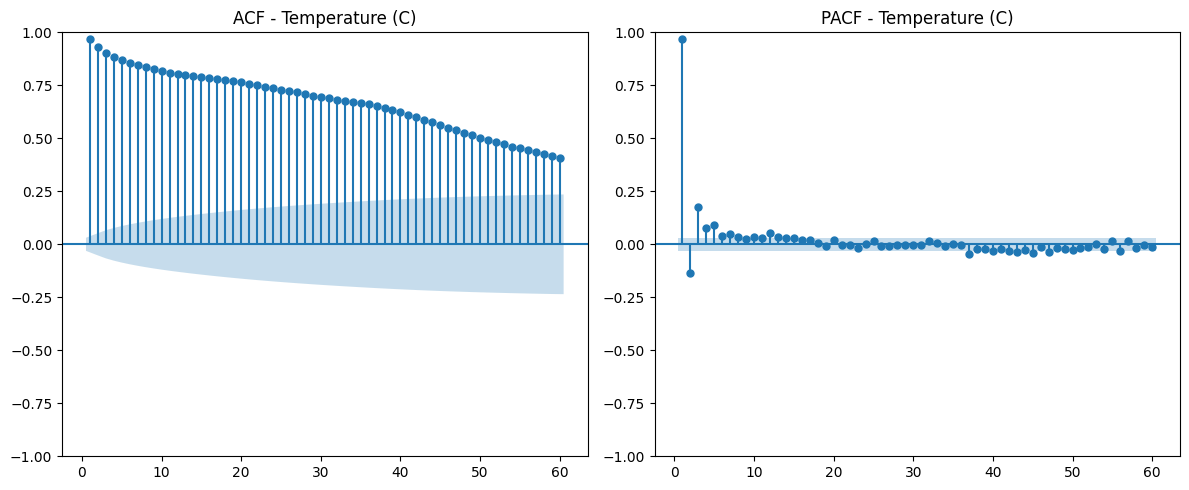

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#plot acf to show correlation of data with lagged values (detects AR through slow decay)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(temp_series.dropna(), lags=60, zero=False, ax=plt.gca())
plt.title("ACF - Temperature (C)")

#plot pacf measure correlation after removing effects of shorter lags (quick cutoff is AR)
plt.subplot(1,2,2)
plot_pacf(temp_series.dropna(), lags=60, method='ywm', zero=False, ax=plt.gca())
plt.title("PACF - Temperature (C)")

plt.tight_layout()
plt.show()

**Explain the reasons for your choice of (p,d,q)** I chose 1 for d because even though from before we know no differencing is needed, the acf plot slowly tapers off indicating nonstationary. On the pacf plot there is a large spike at lag 1 and it quickly drops to near zero right after, which indicates AR. For q I chose 0 because both graphs indicate no MA evidence (the ACF graph tapers off slowly, and the other graph drops quickly). For p I chose 1 because again the sharp start at lag 1 (reason for value) with a quick decline of PACF indicates AR (MA would have gradual fall not sharp).

In [23]:
import pmdarima as pm

#num of days to hold out for testing
test_horiz=365

#train and test sets
train=temp_series[:-test_horiz]
test=temp_series[:-test_horiz:]

#print info about sets
print(f"Train: {train.index.min().date()} → {train.index.max().date()} ({len(train)} days)")
print(f"Test:  {test.index.min().date()} → {test.index.max().date()} ({len(test)} days)")

#use auto_arima to select best parameters 
auto_model=pm.auto_arima(
    train.dropna(), 
    start_p=0, max_p=3,      #try AR orders from 0 to 3
    start_q=0, max_q=3,      #try MA orders from 0 to 3
    d=None,                  #let model choose the d
    seasonal=False,          #no season
    stepwise=True,   
    suppress_warnings=True,
    information_criterion='aic',  #use AIC to select the best model
    trace=True
)

best_order = auto_model.order
print(f"\nAuto ARIMA selected order: (p,d,q) = {best_order}")

Train: 2005-12-31 → 2016-01-01 (3654 days)
Test:  2005-12-31 → 2016-01-01 (3654 days)
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30081.225, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16156.974, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=25603.048, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=16098.031, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16035.510, Time=0.67 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=16068.673, Time=0.41 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=15864.261, Time=1.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=15851.208, Time=2.82 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=15849.507, Time=2.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=15982.338, Time=0.23 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=15851.746, Time=0.80 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=15916.622, Time=0.74 sec
 ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

#make model
model = ARIMA(train.dropna(), order=best_order)
model_fit = model.fit()
print(model_fit.summary())

#make predictions
start = len(train)
end = len(train) + len(test) - 1
pred_mean = model_fit.predict(start=start, end=end, dynamic=False)

#calculate metrics
mae = mean_absolute_error(test, pred_mean)
mse = mean_squared_error(test, pred_mean)
print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")


c:\Users\sixel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\sixel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\sixel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\sixel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:        Temperature (C)   No. Observations:                 3654
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7915.703
Date:                Tue, 23 Sep 2025   AIC                          15843.406
Time:                        17:07:21   BIC                          15880.627
Sample:                    12-31-2005   HQIC                         15856.661
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4744      2.277      5.039      0.000       7.012      15.937
ar.L1          1.6410      0.031     52.639      0.000       1.580       1.702
ar.L2         -0.6436      0.031    -20.980      0.0

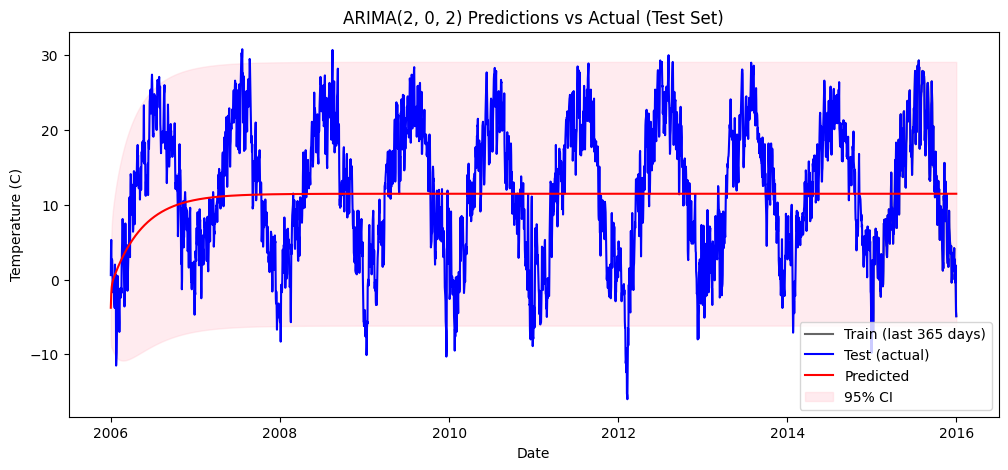

In [ ]:
#forecast for test set using model
forecast_steps = len(test)
forecast = model_fit.get_forecast(steps=forecast_steps)
pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int(alpha=0.05) #upper and lower bounds of interval 

#reset indexes of outputs so that they line up with my test indexes
pred_mean.index = test.index
pred_ci.index = test.index

#plot training test and predictions
plt.figure(figsize=(12,5))
#plot training set
plt.plot(train.index[-365:], train[-365:], label='Train (last 365 days)', color='black', alpha=0.6)
#plot actual test values
plt.plot(test.index, test, label='Test (actual)', color='blue')
#plot predictions
plt.plot(pred_mean.index, pred_mean, label='Predicted', color='red')

#plot 95% confidence interval
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:,0],
                 pred_ci.iloc[:,1],
                 color='pink', alpha=0.3, label='95% CI')

plt.title(f"ARIMA{best_order} Predictions vs Actual (Test Set)")
plt.xlabel("Date")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()


this tells me the ARIMA model does not fit my data because it is so bad and flat and my test data fluctuates a lot. To make this better I would have to use SARIMA.

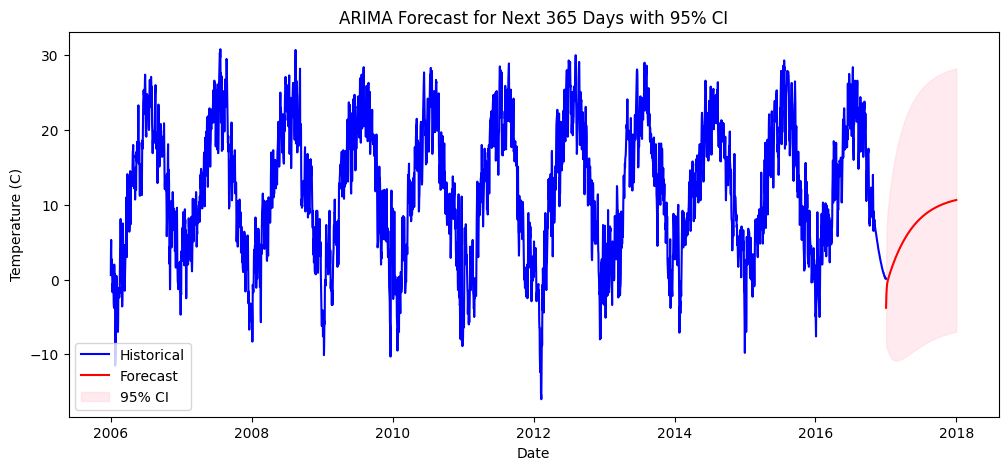

In [ ]:
#predict next year values
future_forecast = model_fit.get_forecast(steps=365)
forecast_mean = future_forecast.predicted_mean
forecast_ci = future_forecast.conf_int(alpha=0.05)

#create future dates starting one day after last observation in data
future_dates = pd.date_range(start=temp_series.index[-1] + pd.Timedelta(days=1),
                             periods=365, freq='D')

#reassign forecast index 
forecast_mean.index = future_dates
forecast_ci.index = future_dates

#plot historical and preidcted
plt.figure(figsize=(12,5))
plt.plot(temp_series.index, temp_series, label='Historical', color='blue')
plt.plot(future_dates, forecast_mean, label='Forecast', color='red')
plt.fill_between(future_dates,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color='pink', alpha=0.3, label='95% CI')

plt.title("ARIMA Forecast for Next 365 Days with 95% CI")
plt.xlabel("Date")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()


This tells me that the model is again bad because its too flat

### Q2.2 SARIMA forecasting (15%)

1. Derive a **monthly** series from `daily_clean` and fit a **SARIMA** with seasonal period **12**. Hold out the **last 24 months** as test set for prediction. 
2. Report the predictions' **MAE/MSE**.
3. Plot the the prediction with **95% CI** 
4.  **Discussion:** Compare the ARIMA and SARIMA predictions and explain your findings.


In [ ]:
#create monnthly data series using mean aggregation 
month=daily_clean['Temperature (C)'].resample('M').mean()

#train/test split (24 months)
test_horiz=24
train_month=month[:-test_horiz]
test_monthly = month[-test_horiz:]

print(f"Monthly series length: {len(month)} months")
print(f"Train: {train_month.index.min().date()} → {train_month.index.max().date()} ({len(train_month)} months)")
print(f"Test:  {test_monthly.index.min().date()} → {test_monthly.index.max().date()} ({len(test_monthly)} months)")

Monthly series length: 133 months
Train: 2005-12-31 → 2014-12-31 (109 months)
Test:  2015-01-31 → 2016-12-31 (24 months)


C:\Users\sixel\AppData\Local\Temp\ipykernel_35324\2906766140.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month=daily_clean['Temperature (C)'].resample('M').mean()


In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#use SARIMA 1,1,1 1,1,1,12 to start

sarima_model = SARIMAX(train_month,
                       order=(1,1,1,),
                       seasonal_order=(1,1,1,12),
                       enforce_stationarity=False,
                       enforce_invertibility=False).fit()
print(sarima_model.summary())

#predict test set
sarima_fc_obj = sarima_model.get_forecast(steps=test_horiz)
sarima_fc_mean = sarima_fc_obj.predicted_mean
sarima_fc_ci=sarima_fc_obj.conf_int(alpha=0.05)

#compute errors
mae_sarima = mean_absolute_error(test_monthly,sarima_fc_mean)
mse_sarima = mean_squared_error(test_monthly,sarima_fc_mean)
print(f"SARIMA Test MAE: {mae_sarima:.4f}, MSE: {mse_sarima:.4f}")

                                     SARIMAX Results                                      
Dep. Variable:                    Temperature (C)   No. Observations:                  109
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -174.039
Date:                            Thu, 25 Sep 2025   AIC                            358.079
Time:                                    12:16:48   BIC                            370.112
Sample:                                12-31-2005   HQIC                           362.910
                                     - 12-31-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1714      0.134      1.278      0.201      -0.091       0.434
ma.L1         -1.0546      0.117   

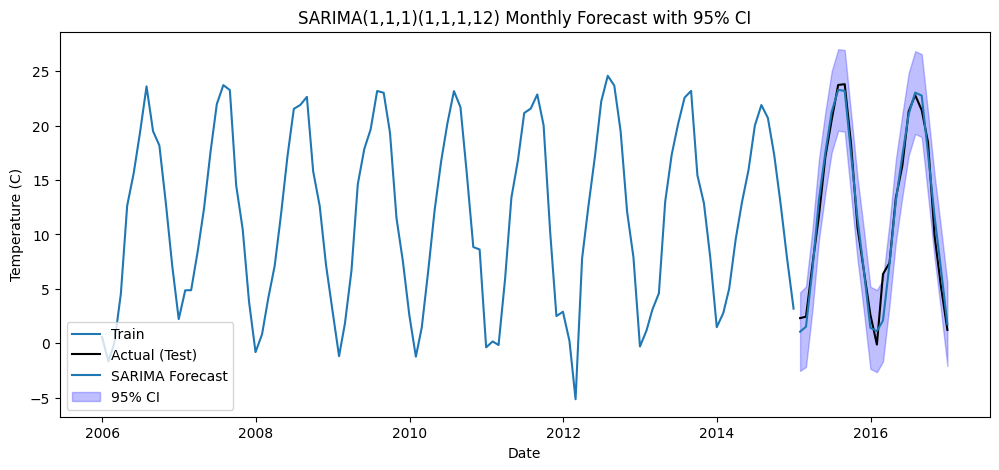

In [40]:
plt.figure(figsize=(12,5))
plt.plot(train_month.index, train_month, label='Train')
plt.plot(test_monthly.index, test_monthly, label='Actual (Test)', color='black')
plt.plot(sarima_fc_mean.index, sarima_fc_mean, label='SARIMA Forecast', color='tab:blue')
plt.fill_between(sarima_fc_mean.index, 
                 sarima_fc_ci.iloc[:,0], 
                 sarima_fc_ci.iloc[:,1], 
                 color='blue', alpha=0.25, label='95% CI')
plt.title("SARIMA(1,1,1)(1,1,1,12) Monthly Forecast with 95% CI")
plt.xlabel("Date")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

**Compare the ARIMA and SARIMA predictions and explain your findings.** As seen from the mse and mae, the properties are much better for the SARIMA plot. Not only are these better, but the actual plot itself is exponentially better. The predicted values actually follow the seasonal and individual trends due to the seasonality aspect of the SARIMA vs the ARIMA model.

## Question 3: Neural Networks for Time Series Forecasting (40%)
Use `daily_clean` for all parts.

### Q3.1 Sliding Window for Time Series — Univariate (2%)
1. Restructure **Temperature**: past **10 days** → **next day**.

2. Hold out last 20% as test set.


In [45]:
import numpy as np 

#extract temperature column from data
temp_series=daily_clean['Temperature (C)'].values

window_size=10
#function to do sliding windows 
def slide_window(data):
    x,y,=[],[]
    for i in range(len(data)-window_size):
        x.append(data[i:i+window_size]) #past 10 days
        y.append(data[i+window_size]) #next day
    return np.array(x), np.array(y)

#create dataset with window size 10
x,y = slide_window(temp_series)

print(f"Shape of X: {x.shape}, Shape of y: {y.shape}")

Shape of X: (4009, 10), Shape of y: (4009,)


In [46]:
#split into 80 20 split
xtrain, xtest= x[:int(0.8 * len(x))], x[int(0.8 * len(x)):]
ytrain, ytest= y[:int(0.8 * len(y))], y[int(0.8 * len(y)):]

print(f"Train size: {len(xtrain)}, Test size: {len(xtest)}")

Train size: 3207, Test size: 802


### Q3.2 MLP — Univariate (18%)
1. Build an MLP with one hidden layer of 64 neurons, ReLu activation, Adam optimizer with learning rate of 0.001 and batch_size=32, and train it for 20 epochs. 
2. Report **RMSE/MAE**.
3. Plot **two figures**: (1) **last 100 test points** (true vs. predicted), (2) **scatter (true vs. predicted)** with the **y = x** line.
4. **Discussion:** Compare ARIMA vs. the univariate MLP in **RMSE/MAE** and **plots**. Which patterns does each capture better? 
5. **Discussion:** Would increasing the input window beyond 10 days help? Why or why not?


In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


#normalize data
scalerX = MinMaxScaler()
scalery = MinMaxScaler()
xtrain_scaled = scalerX.fit_transform(xtrain)
xtest_scaled = scalerX.transform(xtest)
ytrain_scaled = scalery.fit_transform(ytrain.reshape(-1,1))
ytest_scaled = scalery.transform(ytest.reshape(-1,1))

#build model
mlp_model = Sequential([
    #dense hidden layer with 64 neurons, relu (nonlin)
    Dense(64, activation = 'relu', input_shape=(xtrain_scaled.shape[1],)),
    Dense(1) #output layer
])
#use adam because its good at complex things
mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#train
#use 20 epochs because its low enough to avoid overfitting since its only 3200 variables
history=mlp_model.fit(xtrain_scaled,ytrain_scaled, epochs=20, batch_size=32, validation_split=0.1, verbose =1)

c:\Users\sixel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1312 - val_loss: 0.0027
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_lo

In [54]:
#predict on test set
ypred_scaled=mlp_model.predict(xtest_scaled)
ypred=scalery.inverse_transform(ypred_scaled)

#compute metrics
rmse = np.sqrt(mean_squared_error(ytest, ypred))
mae = mean_absolute_error(ytest, ypred)
print(f"MLP Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MLP Test RMSE: 2.1636, MAE: 1.6588


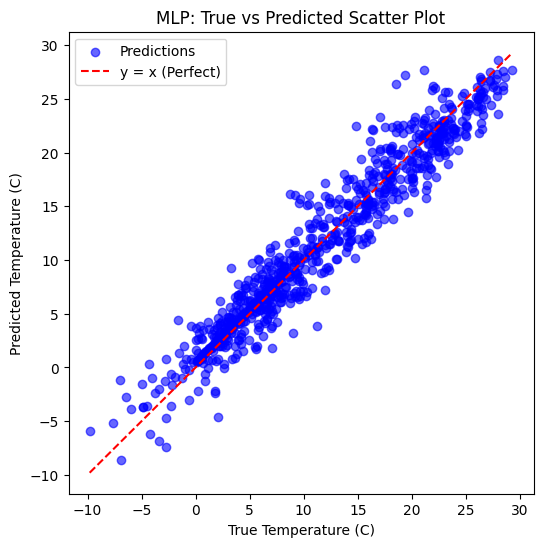

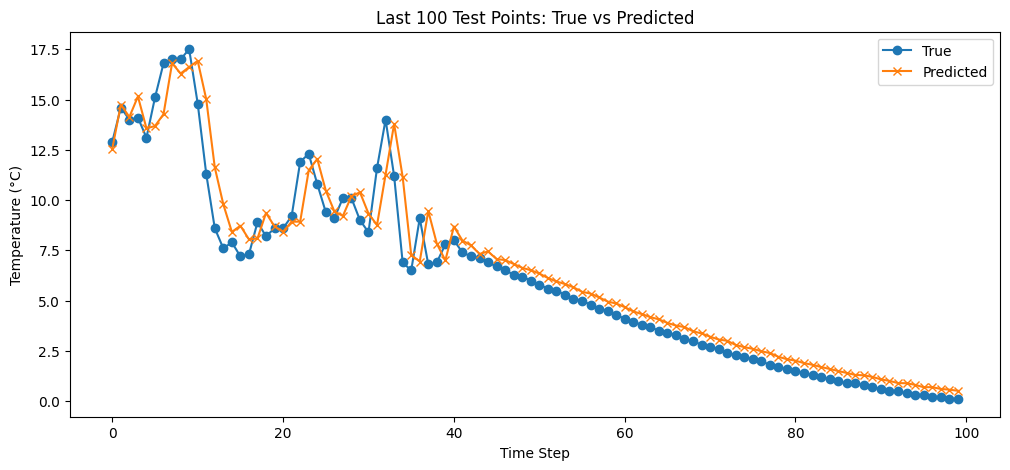

In [58]:
plt.figure(figsize=(6,6))
plt.scatter(ytest, ypred, alpha=0.6, color="blue", label="Predictions")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()],
         'r--', label='y = x (Perfect)')
plt.title("MLP: True vs Predicted Scatter Plot")
plt.xlabel("True Temperature (C)")
plt.ylabel("Predicted Temperature (C)")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(ytest[-100:], label="True", marker='o')
plt.plot(ypred[-100:], label="Predicted", marker='x')
plt.title("Last 100 Test Points: True vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()


**Compare ARIMA vs. the univariate MLP in RMSE/MAE and plots. Which patterns does each capture better?** I think the MLP is better than the regular ARIMA model because it better captured the true values of the test set through its predictions. The MLP also has significantly lower metrics such as MSE. 


**Would increasing the input window beyond 10 days help? Why or why not?** It could help because it would allow us to capture longer term dependencies which would allow for better estimation. But it could be harmful since each delay adds a new neuron so it could overfit and the training complexity would be increased. 

### Q3.3 MLP — Multivariate (20%)
1. Use **Temperature & Pressure** for the past **10 days** as the inputs and **next‑day Temperature** as the target. 
2. Hold out last 20% as test set.
3. Build a Multivariate MLP with one hidden layer of 64 neurons, ReLu activation, Adam optimizer with learning rate of 0.001 and batch_size=32, and train it for 20 epochs. 
4. Report **RMSE/MAE**.
5. Plot **two figures**: (1) **last 100 test points** (true vs. predicted), (2) **scatter (true vs. predicted)** with the **y = x** line.
6. **Discussion:** Did Pressure improve Temperature forecasting vs. univariate? Why might it help/hurt?  
7. **Discussion:** Suggest two additional features you would add next and why?


In [60]:
press_series=daily_clean['Pressure (millibars)'].values

#combine as multivariate array
datamulti=np.column_stack([temp_series,press_series])

#function to create multivariate sliding windows 
def multiwindow (data):
    x, y = [], []
    for i in range(len(data) - window_size):
        x.append(data[i:i+window_size,:])  # past 10 days of 2 features
        y.append(data[i+window_size, 0])   # next-day Temperature only
    return np.array(x), np.array(y)

xmulti, ymulti = multiwindow(datamulti)
print(f"Shape of X_multi: {xmulti.shape}, Shape of y_multi: {ymulti.shape}")

Shape of X_multi: (4009, 10, 2), Shape of y_multi: (4009,)


In [61]:
#flatten to 20 inputs for mlp
xmultiflat=xmulti.reshape(xmulti.shape[0],-1)

#train test split
xtrainmulti, xtestmulti = xmultiflat[:int(0.8 * len(xmultiflat))], xmultiflat[int(0.8 * len(xmultiflat)):]
ytrainmulti, ytestmulti = ymulti[:int(0.8 * len(xmultiflat))], ymulti[int(0.8 * len(xmultiflat)):]

print(f"Train size: {len(xtrainmulti)}, Test size: {len(xtestmulti)}")

Train size: 3207, Test size: 802


In [67]:
#normalize
xtrainscaled=scalerX.fit_transform(xtrainmulti)
xtestscaled=scalerX.transform(xtestmulti)
ytrainscaled=scalery.fit_transform(ytrainmulti.reshape(-1,1))
ytestscaled=scalery.transform(ytestmulti.reshape(-1,1))

#build mlp
#build model
mlp_multi = Sequential([
    #dense hidden layer with 64 neurons, relu (nonlin)
    Dense(64, activation = 'relu', input_shape=(xtrainscaled.shape[1],)),
    Dense(1) #output layer
])
#use adam because its good at complex things
mlp_multi.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#train
#use 20 epochs because its low enough to avoid overfitting since its only 3200 variables
history=mlp_multi.fit(xtrainscaled,ytrainscaled, epochs=20, batch_size=32, validation_split=0.1, verbose =1)

Epoch 1/20


c:\Users\sixel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6741 - val_loss: 0.0066
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - val_loss: 0.0046
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - val_loss: 0.0031
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0020


In [68]:
#predict on test set
ypredscaled=mlp_multi.predict(xtestscaled)
ypred=scalery.inverse_transform(ypredscaled)

rmse = np.sqrt(mean_squared_error(ytestmulti, ypred))
mae = mean_absolute_error(ytestmulti, ypred)
print(f"Multivariate MLP Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Multivariate MLP Test RMSE: 2.4171, MAE: 1.9123


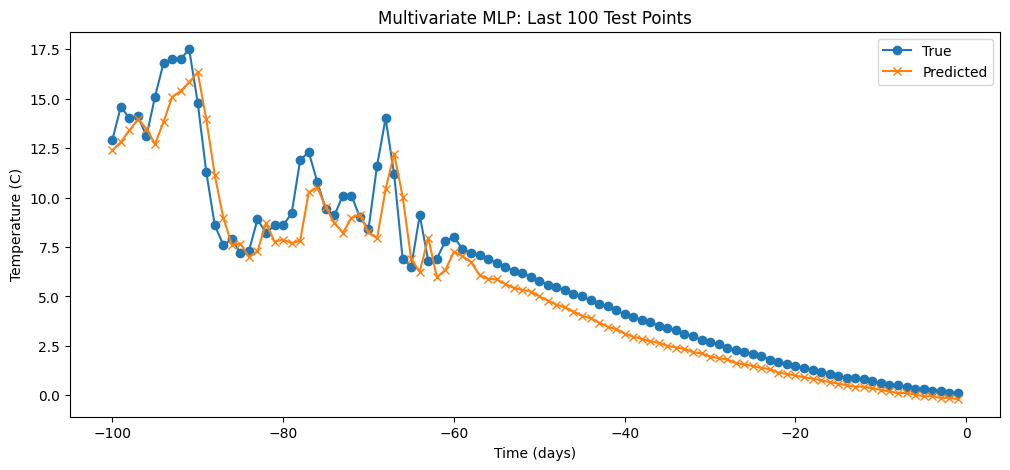

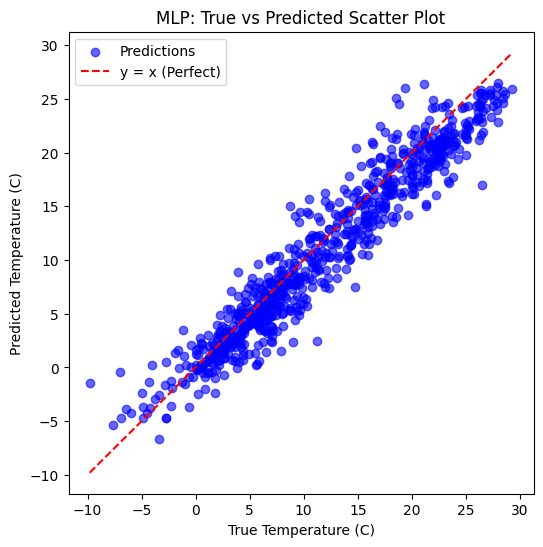

In [69]:
plt.figure(figsize=(12,5))
plt.plot(range(-100,0), ytestmulti[-100:], label='True', marker='o')
plt.plot(range(-100,0), ypred[-100:], label='Predicted', marker='x')
plt.title("Multivariate MLP: Last 100 Test Points")
plt.xlabel("Time (days)")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(ytest, ypred, alpha=0.6, color="blue", label="Predictions")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()],
         'r--', label='y = x (Perfect)')
plt.title("MLP: True vs Predicted Scatter Plot")
plt.xlabel("True Temperature (C)")
plt.ylabel("Predicted Temperature (C)")
plt.legend()
plt.show()


**Did Pressure improve Temperature forecasting vs. univariate? Why might it help/hurt?** I do not think pressure improved the forecasting because the metrics remained really similar and the plot also did. Adding variables couldve helped because adding physical correlation could add context for trends to better help forecasting, but it also couldve harmed it by adding irrelavent data and therefore adding noise and complexity for no reason

**Suggest two additional features you would add next and why?** I would add humidity because it affects the heat content of the air and i think this would have high correlation with Temperature and add valuable data to the model. I would also add wind speed as wind can transport heat/cold from different regions leading to faster temperature changes.